In [1]:
!pip install --quiet -U "wandb" "lightning" "mediapipe"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.2/20.2 MB 84.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 827.9/827.9 kB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 52.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 101.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 77.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import os
import gc # Python garbage collector to identity and reclaim memory
import time
import random
import wandb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import lightning as L
import torch
import torch.nn as nn
import torchvision
import mediapipe as mp

from torchmetrics import MetricCollection, Accuracy, F1Score
from PIL import Image
from torchvision import transforms as T, datasets
from torch.utils.data import random_split, DataLoader, Dataset
from lightning.pytorch.callbacks import LearningRateMonitor, ModelCheckpoint, EarlyStopping
from lightning.pytorch.loggers import WandbLogger, CSVLogger
from lightning.pytorch import LightningDataModule
from sklearn.model_selection import train_test_split
from PIL import Image, ImageDraw

2025-11-21 06:30:59.760408: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763706660.175121      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763706660.300815      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
def collectors():
    if torch.accelerator.is_available():
        torch.accelerator.memoty.empty_cahce()

    gc.collect()

L.seed_everything(42)
NUM_WORKERS = os.cpu_count()

DNORMAL_PATH = "/kaggle/input/acrig-daisee-confusion-det-landmark-dataset/landmark_dataset_normal"
DUNDER_PATH = "/kaggle/input/acrig-daisee-confusion-det-landmark-dataset/landmark_dataset_oversampling"
DOVER_PATH = "/kaggle/input/acrig-daisee-confusion-det-landmark-dataset/landmark_dataset_undersampling"

Seed set to 42


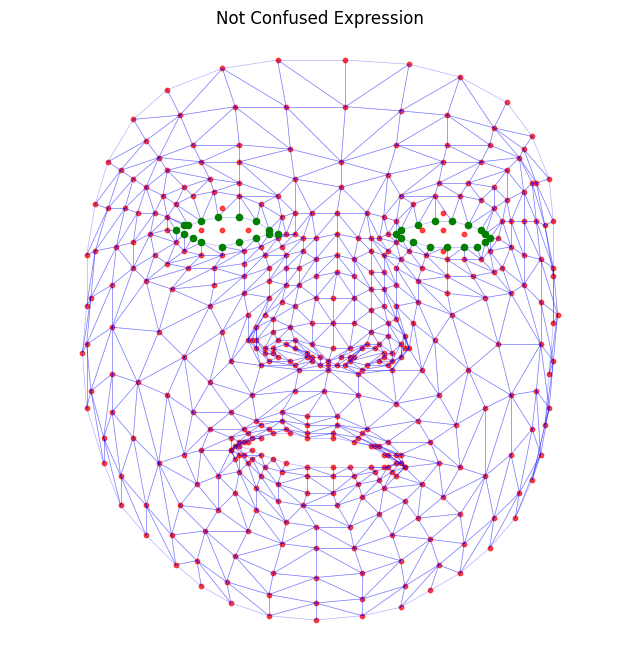

In [4]:
def visualize_landmarks_as_face(landmarks, title="Facial Landmarks", save_path=None):
    """Visualize landmarks in face-like anatomical layout"""
    plt.figure(figsize=(8, 8))
    
    # Plot all landmarks as points
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, c='red', alpha=0.7)
    
    # Connect key facial regions using MediaPipe connections
    face_mesh = mp.solutions.face_mesh
    
    # Draw facial connections
    for connection in face_mesh.FACEMESH_TESSELATION:
        start_idx, end_idx = connection
        plt.plot([landmarks[start_idx, 0], landmarks[end_idx, 0]], 
                [landmarks[start_idx, 1], landmarks[end_idx, 1]], 
                'b-', linewidth=0.5, alpha=0.3)
    
    # Highlight important regions
    eye_landmarks = list(mp.solutions.face_mesh.FACEMESH_LEFT_EYE) + \
                   list(mp.solutions.face_mesh.FACEMESH_RIGHT_EYE)
    eye_indices = set([idx for edge in eye_landmarks for idx in edge])
    
    for idx in eye_indices:
        plt.scatter(landmarks[idx, 0], landmarks[idx, 1], s=20, c='green', zorder=5)
    
    plt.gca().invert_yaxis()  # Match image coordinate system
    plt.title(title)
    plt.axis('equal')
    plt.axis('off')
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()

# Example usage
landmark_file = "/kaggle/input/acrig-daisee-confusion-det-landmark-dataset/landmark_dataset_normal/0_tidak_bingung/1100011002.npy"
landmarks = np.load(landmark_file)
visualize_landmarks_as_face(landmarks, "Not Confused Expression")

In [5]:
landmarks.shape

(478, 2)

In [6]:
class LandmarkToImageDataset(Dataset):
    def __init__(self, data, labels, img_size=224):
        self.data = data
        self.labels = labels
        self.img_size = img_size

        # Use a very simple transform: to tensor only
        self.transform = T.ToTensor()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        landmarks = self.data[idx]      # shape (478, 2)
        label = self.labels[idx]

        img = self.landmarks_to_image(landmarks)

        img = self.transform(img)       # (1, H, W)

        return img, label

    def landmarks_to_image(self, landmarks):
        # Create a 1-channel blank image (white background)
        img = Image.new('L', (self.img_size, self.img_size), color=255)
        draw = ImageDraw.Draw(img)

        pts = self.normalize_landmarks(landmarks)

        radius = 1
        for x, y in pts:
            draw.ellipse(
                [x - radius, y - radius, x + radius, y + radius],
                fill=0
            )

        return img

    def normalize_landmarks(self, pts):
        pts = np.array(pts)
        x = pts[:, 0]
        y = pts[:, 1]

        # Normalization with padding
        pad = 0.05
        xmin, xmax = x.min(), x.max()
        ymin, ymax = y.min(), y.max()

        w = xmax - xmin
        h = ymax - ymin

        xmin -= w * pad
        xmax += w * pad
        ymin -= h * pad
        ymax += h * pad

        # Scale preserving aspect ratio
        sx = (self.img_size - 1) / (xmax - xmin)
        sy = (self.img_size - 1) / (ymax - ymin)
        s = min(sx, sy)

        xc = (xmin + xmax) / 2
        yc = (ymin + ymax) / 2

        cx = self.img_size / 2
        cy = self.img_size / 2

        x_new = (x - xc) * s + cx
        y_new = (y - yc) * s + cy

        return np.stack([x_new, y_new], axis=1)


In [7]:
class DAiSEELandmarkDM(L.LightningDataModule):
    def __init__(self, data_dir, batch_size=32, img_size=224, num_workers=4, seed=42):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.img_size = img_size
        self.num_workers = num_workers
        self.seed = seed

    def load_landmark_data(self):
        confused_dir = os.path.join(self.data_dir, "1_bingung")
        not_confused_dir = os.path.join(self.data_dir, "0_tidak_bingung")

        data = []
        labels = []

        for f in os.listdir(confused_dir):
            if f.endswith(".npy"):
                data.append(np.load(os.path.join(confused_dir, f)))
                labels.append(1)

        for f in os.listdir(not_confused_dir):
            if f.endswith(".npy"):
                data.append(np.load(os.path.join(not_confused_dir, f)))
                labels.append(0)

        return np.array(data), np.array(labels)

    def setup(self, stage=None):
        data, labels = self.load_landmark_data()

        X_train, X_test, y_train, y_test = train_test_split(
            data, labels, test_size=0.2, stratify=labels, random_state=self.seed
        )

        X_train, X_val, y_train, y_val = train_test_split(
            X_train, y_train, test_size=0.25, stratify=y_train, random_state=self.seed
        )

        if stage == "fit" or stage is None:
            self.train_dataset = LandmarkToImageDataset(X_train, y_train, img_size=self.img_size)
            self.val_dataset = LandmarkToImageDataset(X_val, y_val, img_size=self.img_size)

        if stage == "test" or stage is None:
            self.test_dataset = LandmarkToImageDataset(X_test, y_test, img_size=self.img_size)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True,
                          num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False,
                          num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False,
                          num_workers=self.num_workers)


In [8]:
try:
    dm_normal = DAiSEELandmarkDM(data_dir=DNORMAL_PATH)
    dm_under = DAiSEELandmarkDM(data_dir=DUNDER_PATH)
    dm_over = DAiSEELandmarkDM(data_dir=DOVER_PATH)
except Exception as e:
    print(f"An error occured: {type(e).__name__} – {e}")
    pass


In [9]:
dm = dm_normal
dm.prepare_data()
dm.setup(stage="fit")

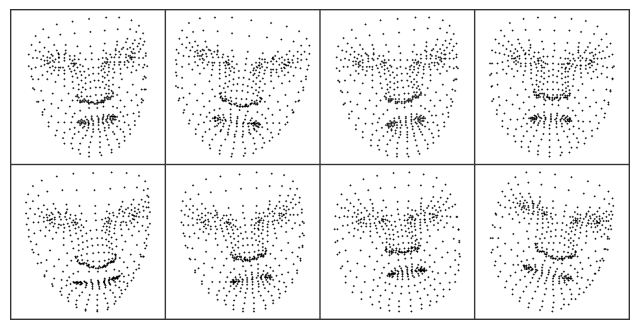

In [10]:
NUM_IMGS = 8
images = torch.stack([dm.train_dataset[idx][0] for idx in range(NUM_IMGS)])
grid = torchvision.utils.make_grid(images, nrow=4, normalize=True, pad_value=0.2)
plt.figure(figsize=(8,8))
plt.imshow(grid.permute(1, 2, 0))
# plt.title(class_names[labels])
plt.axis("off")
plt.show()

## Model creation

In [11]:
class NNModule(nn.Module):
    def __init__(self, num_classes=2, c_t=512, act_fn=nn.SiLU, dropout=0.2):
        super().__init__()
        
        self.model = torchvision.models.efficientnet_b0(weights='DEFAULT')
        
        # --- Replace first conv (3→32) with grayscale conv (1→32) ---
        first_conv = self.model.features[0][0]   # old Conv2d(3→32)

        new_conv = nn.Conv2d(
            in_channels=1,
            out_channels=first_conv.out_channels,
            kernel_size=first_conv.kernel_size,
            stride=first_conv.stride,
            padding=first_conv.padding,
            bias=False
        )

        # Convert pretrained RGB weights → 1-channel by averaging
        with torch.no_grad():
            new_conv.weight = nn.Parameter(
                first_conv.weight.mean(dim=1, keepdim=True)
            )

        # Replace the layer
        self.model.features[0][0] = new_conv

        # --- Replace classifier ---
        self.model.classifier = nn.Identity()

        # EfficientNet-B0 output dimension = 1280
        self.fc = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(1280, c_t),
            act_fn(),
            nn.Dropout(p=dropout),
            nn.Linear(c_t, c_t // 2),
            act_fn(),
            nn.Dropout(p=dropout),
            nn.Linear(c_t // 2, num_classes),
        )

    def forward(self, x):
        x = self.model(x)
        x = self.fc(x)
        return x


In [12]:
class DLModule(L.LightningModule):
    def __init__(self,
                 model_name: str,
                 model_hparams: dict,
                 optimizer_name: str,
                 optimizer_hparams: dict):
        super().__init__()
        self.save_hyperparameters(ignore=['large_object']) if hasattr(self, 'save_hyperparameters') else None
        self.model = NNModule(**model_hparams)

        self.task = "binary"
        self.num_classes = None if self.task == "binary" else model_hparams.get('num_classes')
        self.loss_fn = nn.BCEWithLogitsLoss() if self.task == "binary" else nn.CrossEntropyLoss()
        metric_args = {"task": self.task, "num_classes": self.num_classes}
        self.metrics = MetricCollection({
            "train_acc": Accuracy(**metric_args),
            "val_acc": Accuracy(**metric_args),
            "val_f1": F1Score(**metric_args, average='macro'),
            "test_acc": Accuracy(**metric_args),
            "test_f1_macro": F1Score(**metric_args, average='macro'),
            "test_f1_weighted": F1Score(**metric_args, average='weighted'),
        })
        
    # def on_fit_start(self):
    #     self.metrics = self.metrics.to(self.device)

    def forward(self, imgs):
        return self.model(imgs)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), **self.hparams.optimizer_hparams)
        scheduler = {
            "scheduler": torch.optim.lr_scheduler.ReduceLROnPlateau(
                optimizer, mode="min", factor=0.1, patience=10
            ),
            "monitor": "val_loss", 
        }
        return [optimizer], [scheduler]

    def _process_batch(self, batch):
        x, y = batch
        if self.task == "binary":
            y = y.float().unsqueeze(1)
        probs = self(x)
        return x, y , probs

    def _shared_step(self, batch, step_type: str):
        """Shared logic for training/validation/test steps"""
        x, y, preds = self._process_batch(batch)
        loss = self.loss_fn(preds, y)
        
        self.log(f"{step_type}_loss", loss, prog_bar=True)
        
        # Log metrics for validation and test
        if step_type in ["val", "test"]:
            acc = self.metrics[f"{step_type}_acc"](preds, y)
            self.log(f"{step_type}_acc", acc, prog_bar=True)
            
            if step_type == "val":
                f1 = self.metrics["val_f1"](preds, y)
                self.log("val_f1", f1, prog_bar=True)
            else:  # test
                f1_macro = self.metrics["test_f1_macro"](preds, y)
                f1_weighted = self.metrics["test_f1_weighted"](preds, y)
                self.log("test_f1_macro", f1_macro)
                self.log("test_f1_weighted", f1_weighted)
        
        return loss if step_type == "train" else None

    def training_step(self, batch, batch_idx):
        return self._shared_step(batch, "train")
    
    def validation_step(self, batch, batch_idx):
        self._shared_step(batch, "val")
    
    def test_step(self, batch, batch_idx):
        self._shared_step(batch, "test")

In [13]:
def train_experiment(model_name, dataset_name, optimizer_name, 
                     model_hparams, optimizer_hparams,
                     data_module,seed=42, max_epochs=100):
    
    L.seed_everything(seed)
    experiment_name = f"{model_name}_{dataset_name}_{optimizer_name}_seed{seed}"
    try:
        logger = WandbLogger(
            offline=True,
            name=experiment_name,
            project="ACRIG-DAiSEE-binary_confusion_detection",
            config={
                "model_name": model_name,
                "dataset_name": dataset_name,
                "optimizer_name": optimizer_name,
                "model_hparams": model_hparams,
                "optimizer_hparams": optimizer_hparams,
                "seed": seed,
                "max_epochs": max_epochs,
            },
        )
        print("WandB logger initialized successfully")
    except Exception as e:
        print(f"WandB Logger failed: {e}")
        print("Falling back to CSV logger")
        logger = CSVLogger(
            save_dir="logs",
            name=experiment_name
        )

    model = DLModule(
        model_name=model_name,
        model_hparams=model_hparams,
        optimizer_name=optimizer_name,
        optimizer_hparams=optimizer_hparams
    )
    
    trainer = L.Trainer(
        default_root_dir=f"checkpoints/{experiment_name}",
        accelerator="auto",
        devices=1,
        max_epochs=max_epochs,
        logger=logger,
        callbacks=[
            ModelCheckpoint(
                save_weights_only=True, 
                mode="max", 
                monitor="val_acc",
                dirpath=f"checkpoints/{experiment_name}",
                filename="best-checkpoint",
            ),
            LearningRateMonitor("epoch"),
            EarlyStopping(monitor="val_loss", mode="min", patience=10),
        ],
        log_every_n_steps=10,
    )

    trainer.fit(model, datamodule=data_module)

    try:
        macs, params = get_model_complexity_info(
            model.model, 
            (3, 224, 224),
            as_strings=False,
            print_per_layer_stat=False,
            verbose=False
        )
        fwd_flops = macs * 2  
        num_params = params
    except:
        fwd_flops = 0
        num_params = sum(p.numel() for p in model.parameters())

    test_results = trainer.test(model, datamodule=data_module)

    if test_results and len(test_results) > 0:
        test_result = test_results[0]
        test_acc = test_result.get('test_acc', 0.0)
        test_f1_macro = test_result.get('test_f1_macro', 0.0)
        test_f1_weighted = test_result.get('test_f1_weighted', 0.0)
    else:
        test_acc = test_acc_top5 = test_f1_macro = test_f1_weighted = 0.0

    model.eval()
    latencies = []
    test_loader = data_module.test_dataloader()
    num_batches = min(50, len(test_loader))
    
    device = next(model.parameters()).device
    
    with torch.inference_mode():
        for i, (x, _) in enumerate(test_loader):
            if i >= num_batches:
                break
            x = x.to(device)
            if device.type == "cuda":
                torch.cuda.synchronize()
            start = time.perf_counter()
            _ = model(x)
            if device.type == "cuda":
                torch.cuda.synchronize()
            end = time.perf_counter()
            latencies.append((end - start) / x.size(0))
    
    avg_latency_ms = np.mean(latencies) * 1000 if latencies else float('nan')

    if hasattr(logger, 'experiment') and logger.experiment is not None:
        try:
            metrics_to_log = {
                "num_parameters": num_params,
                "avg_inference_latency_ms": avg_latency_ms,
                "test_acc": test_acc,
                "test_f1_macro": test_f1_macro,
                "test_f1_weighted": test_f1_weighted,
            }
            if fwd_flops > 0:
                metrics_to_log["flops"] = fwd_flops
                
            logger.experiment.log(metrics_to_log)
            logger.experiment.finish()
            print(f"Successfully finished WandB run: {experiment_name}")
        except Exception as e:
            print(f"Failed to finish WandB run: {e}")
    elif 'CSVLogger' in str(type(logger)):
        # Log to CSV as well
        final_metrics = {
            "final_num_parameters": num_params,
            "final_avg_inference_latency_ms": avg_latency_ms,
        }
        if fwd_flops > 0:
            final_metrics["final_flops"] = fwd_flops
        logger.log_metrics(final_metrics)

    wandb.finish()

    return {
        "test_acc": test_acc,
        "test_f1_macro": test_f1_macro,
        "test_f1_weighted": test_f1_weighted,
        "model_metrics": {
            "num_params": num_params,
            "flops": fwd_flops,
            "avg_inference_time": np.mean(latencies) if latencies else float('nan'),
        }
    }

In [14]:
def run_all_experiments(epochs=10):
    experiments = [
        {
            "model_name": "effnetb0-binary-landmark",
            "dataset_name": "normal", 
            "data_module": dm_normal,
            "model_hparams": {"num_classes": 1},
            "optimizer_hparams": {"lr": 1e-3, "weight_decay": 1e-4}
        },
        {
            "model_name": "effnetb0-binary-landmark",
            "dataset_name": "under", 
            "data_module": dm_under,
            "model_hparams": {"num_classes": 1},
            "optimizer_hparams": {"lr": 1e-3, "weight_decay": 1e-4}
        },
        {
            "model_name": "effnetb0-binary-landmark", 
            "dataset_name": "over",
            "data_module": dm_over,
            "model_hparams": {"num_classes": 1},
            "optimizer_hparams": {"lr": 1e-3, "weight_decay": 1e-4}
        }
    ]
    
    results = {}
    for exp_config in experiments:
        print(f"\n{'='*50}")
        print(f"Starting experiment: {exp_config['model_name']} on {exp_config['dataset_name']}")
        print(f"{'='*50}")
        
        result = train_experiment(
            model_name=exp_config["model_name"],
            dataset_name=exp_config["dataset_name"],
            optimizer_name="Adam",
            model_hparams=exp_config["model_hparams"],
            optimizer_hparams=exp_config["optimizer_hparams"],
            data_module=exp_config["data_module"],
            seed=42,
            max_epochs=epochs
        )
        
        results[f"{exp_config['model_name']}_{exp_config['dataset_name']}"] = result
        
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        gc.collect()
    
    return results

In [15]:
run_all_experiments(epochs=20)

Seed set to 42



Starting experiment: effnetb0-binary-landmark on normal
WandB logger initialized successfully


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 140MB/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
wandb: WARNING `resume` will be ignored since W&B syncing is set to `offline`. Starting a new run with run id p1nb1voe.
wandb: Tracking run with wandb version 0.23.0
wandb: W&B syncing is set to `offline` in this directory. Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.
wandb: Run data is saved locally in ./wandb/offline-run-20251121_063151-p1nb1voe
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name    | Type              | Params | Mode 
------------------------------------------------------
0 | model   | NNModule          | 4.8 M  | train
1 | loss_fn | BCEWithLogitsLoss | 0      | train
2 | metrics | MetricCollection  | 0      | train
-------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.6622039079666138     │
│       test_f1_macro       │    0.3275376856327057     │
│     test_f1_weighted      │    0.3275376856327057     │
│         test_loss         │     1.139732003211975     │
└───────────────────────────┴───────────────────────────┘

wandb: 
wandb: Run history:
wandb: avg_inference_latency_ms ▁
wandb:                    epoch ▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇▇▇▇█
wandb:                  lr-Adam ▁▁▁▁▁▁▁▁▁▁▁
wandb:           num_parameters ▁
wandb:                 test_acc ▁▁
wandb:            test_f1_macro ▁▁
wandb:         test_f1_weighted ▁▁
wandb:                test_loss ▁
wandb:               train_loss ▆▆▇▇██▆▆▆▇▇▇▅█▇▇▇▇▇▆▅▆▅▆▆▅▄▅▃▄▂▃▄▄▃▇▃▂▁▂
wandb:      trainer/global_step ▁▁▁▁▁▂▂▂▂▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
wandb:                       +3 ...
wandb: 
wandb: Run summary:
wandb: avg_inference_latency_ms 45.08031
wandb:                    epoch 11
wandb:                  lr-Adam 0.001
wandb:           num_parameters 4794429
wandb:                 test_acc 0.6622
wandb:            test_f1_macro 0.32754
wandb:         test_f1_weighted 0.32754
wandb:                test_loss 1.13973
wandb:               train_loss 0.183
wandb:      trainer/global_step 1001
wandb:                       +3 ...
wandb: 
wandb:

Successfully finished WandB run: effnetb0-binary-landmark_normal_Adam_seed42


Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
wandb: WARNING `resume` will be ignored since W&B syncing is set to `offline`. Starting a new run with run id w0ia9f5o.



Starting experiment: effnetb0-binary-landmark on under
WandB logger initialized successfully


wandb: Tracking run with wandb version 0.23.0
wandb: W&B syncing is set to `offline` in this directory. Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.
wandb: Run data is saved locally in ./wandb/offline-run-20251121_063553-w0ia9f5o
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name    | Type              | Params | Mode 
------------------------------------------------------
0 | model   | NNModule          | 4.8 M  | train
1 | loss_fn | BCEWithLogitsLoss | 0      | train
2 | metrics | MetricCollection  | 0      | train
------------------------------------------------------
4.8 M     Trainable params
0         Non-trainable params
4.8 M     Total params
19.178    Total estimated model params size (MB)
353       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.6594141721725464     │
│       test_f1_macro       │    0.7246676683425903     │
│     test_f1_weighted      │    0.7246676683425903     │
│         test_loss         │    0.9132742881774902     │
└───────────────────────────┴───────────────────────────┘

wandb: 
wandb: Run history:
wandb: avg_inference_latency_ms ▁
wandb:                    epoch ▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
wandb:                  lr-Adam ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:           num_parameters ▁
wandb:                 test_acc ▁▁
wandb:            test_f1_macro ▁▁
wandb:         test_f1_weighted ▁▁
wandb:                test_loss ▁
wandb:               train_loss ▆█▇▆▇▆▆▇▆▇▆▅▅▆▄▅▄▄▅▃▄▄▇▄▅▂▄▆▄▃▄▁▂▁▁▂▂▂▂▆
wandb:      trainer/global_step ▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇█████
wandb:                       +3 ...
wandb: 
wandb: Run summary:
wandb: avg_inference_latency_ms 398.50514
wandb:                    epoch 16
wandb:                  lr-Adam 0.001
wandb:           num_parameters 4794429
wandb:                 test_acc 0.65941
wandb:            test_f1_macro 0.72467
wandb:         test_f1_weighted 0.72467
wandb:                test_loss 0.91327
wandb:               train_loss 0.28932
wandb:      trainer/global_step 15936
wandb:                       +3 ...
wand

Successfully finished WandB run: effnetb0-binary-landmark_under_Adam_seed42


Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
wandb: WARNING `resume` will be ignored since W&B syncing is set to `offline`. Starting a new run with run id h6wld52r.



Starting experiment: effnetb0-binary-landmark on over
WandB logger initialized successfully


wandb: Tracking run with wandb version 0.23.0
wandb: W&B syncing is set to `offline` in this directory. Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.
wandb: Run data is saved locally in ./wandb/offline-run-20251121_073932-h6wld52r
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name    | Type              | Params | Mode 
------------------------------------------------------
0 | model   | NNModule          | 4.8 M  | train
1 | loss_fn | BCEWithLogitsLoss | 0      | train
2 | metrics | MetricCollection  | 0      | train
------------------------------------------------------
4.8 M     Trainable params
0         Non-trainable params
4.8 M     Total params
19.178    Total estimated model params size (MB)
353       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.5366241931915283     │
│       test_f1_macro       │    0.49533334374427795    │
│     test_f1_weighted      │    0.49533334374427795    │
│         test_loss         │    1.6378318071365356     │
└───────────────────────────┴───────────────────────────┘

wandb: 
wandb: Run history:
wandb: avg_inference_latency_ms ▁
wandb:                    epoch ▁▁▁▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
wandb:                  lr-Adam ▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:           num_parameters ▁
wandb:                 test_acc ▁▁
wandb:            test_f1_macro ▁▁
wandb:         test_f1_weighted ▁▁
wandb:                test_loss ▁
wandb:               train_loss ██▇█▇█▇▇██▇▆▇█▇▄▆▅▇▆█▆▂▄▄▅▃▂▃▃▃▃▂▂▁▂▂▂▂▁
wandb:      trainer/global_step ▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
wandb:                       +3 ...
wandb: 
wandb: Run summary:
wandb: avg_inference_latency_ms 20.80298
wandb:                    epoch 13
wandb:                  lr-Adam 0.001
wandb:           num_parameters 4794429
wandb:                 test_acc 0.53662
wandb:            test_f1_macro 0.49533
wandb:         test_f1_weighted 0.49533
wandb:                test_loss 1.63783
wandb:               train_loss 0.23218
wandb:      trainer/global_step 767
wandb:                       +3 ...
wandb: 
wa

Successfully finished WandB run: effnetb0-binary-landmark_over_Adam_seed42


{'effnetb0-binary-landmark_normal': {'test_acc': 0.6622039079666138,
  'test_f1_macro': 0.3275376856327057,
  'test_f1_weighted': 0.3275376856327057,
  'model_metrics': {'num_params': 4794429,
   'flops': 0,
   'avg_inference_time': 0.04508031197214238}},
 'effnetb0-binary-landmark_under': {'test_acc': 0.6594141721725464,
  'test_f1_macro': 0.7246676683425903,
  'test_f1_weighted': 0.7246676683425903,
  'model_metrics': {'num_params': 4794429,
   'flops': 0,
   'avg_inference_time': 0.3985051447625011}},
 'effnetb0-binary-landmark_over': {'test_acc': 0.5366241931915283,
  'test_f1_macro': 0.49533334374427795,
  'test_f1_weighted': 0.49533334374427795,
  'model_metrics': {'num_params': 4794429,
   'flops': 0,
   'avg_inference_time': 0.02080298024781769}}}

In [16]:
!zip -r wandb_logs.zip wandb

  adding: wandb/ (stored 0%)
  adding: wandb/offline-run-20251121_063151-p1nb1voe/ (stored 0%)
  adding: wandb/offline-run-20251121_063151-p1nb1voe/logs/ (stored 0%)
  adding: wandb/offline-run-20251121_063151-p1nb1voe/logs/debug.log (deflated 74%)
  adding: wandb/offline-run-20251121_063151-p1nb1voe/logs/debug-core.log (deflated 75%)
  adding: wandb/offline-run-20251121_063151-p1nb1voe/logs/debug-internal.log (deflated 71%)
  adding: wandb/offline-run-20251121_063151-p1nb1voe/files/ (stored 0%)
  adding: wandb/offline-run-20251121_063151-p1nb1voe/files/requirements.txt (deflated 57%)
  adding: wandb/offline-run-20251121_063151-p1nb1voe/tmp/ (stored 0%)
  adding: wandb/offline-run-20251121_063151-p1nb1voe/tmp/code/ (stored 0%)
  adding: wandb/offline-run-20251121_063151-p1nb1voe/run-p1nb1voe.wandb (deflated 79%)
  adding: wandb/debug.log (deflated 73%)
  adding: wandb/latest-run/ (stored 0%)
  adding: wandb/latest-run/logs/ (stored 0%)
  adding: wandb/latest-run/logs/debug.log (deflate